# Carga de Ficheros y Librerias

In [36]:
import pandas as pd
import glob
import os
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import GridSearchCV



In [24]:
df = pd.read_csv("temporal_features2.csv")

# Random Forest

In [25]:
y = df['condition']
X = df.drop(columns=['condition'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [26]:
rf = RandomForestClassifier(random_state=42)

non_numeric_cols = X_train.select_dtypes(include=['object']).columns

if len(non_numeric_cols) > 0:
    print(f"Columnas no numericas: {non_numeric_cols.tolist()}")

    # Using drop_first=True to avoid multicollinearity
    X_train_encoded = pd.get_dummies(X_train, columns=non_numeric_cols, drop_first=True)
    X_test_encoded = pd.get_dummies(X_test, columns=non_numeric_cols, drop_first=True)

    train_cols = X_train_encoded.columns
    X_test_aligned = X_test_encoded.reindex(columns=train_cols, fill_value=0)


    X_train = X_train_encoded
    X_test = X_test_aligned
    print("Non-numeric columns one-hot encoded and datasets aligned.")
else:
    print("No non-numeric columns found. Proceeding with original data.")

rf.fit(X_train, y_train)

Columnas no numericas: ['sensor']
Non-numeric columns one-hot encoded and datasets aligned.


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

                         precision    recall  f1-score   support

horizontal-misalignment       0.33      0.23      0.27        26
              imbalance       0.48      0.47      0.47        45
                 normal       0.00      0.00      0.00         6
               overhang       0.55      0.64      0.59        77
              underhang       0.58      0.65      0.61        77
  vertical-misalignment       0.43      0.34      0.38        38

               accuracy                           0.52       269
              macro avg       0.40      0.39      0.39       269
           weighted avg       0.50      0.52      0.50       269



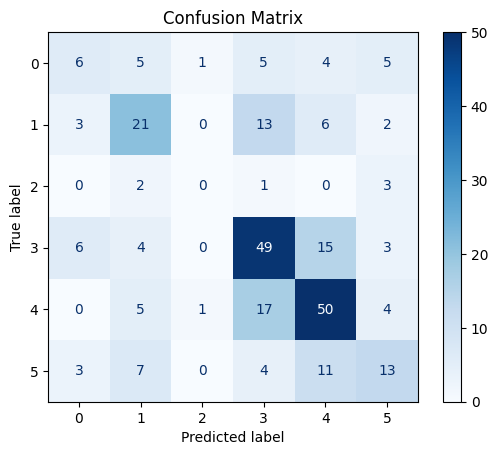

In [27]:
y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))


cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format="d")

plt.title("Confusion Matrix")
plt.show()

# Importance Features

                        feature  importance
8                 zero-crossing    0.122700
6                      kurtosis    0.119239
7                      skewness    0.110618
0                          mean    0.107604
4                           max    0.107039
3                           min    0.103795
5                           ptp    0.101149
1                           std    0.093625
2                           rms    0.088513
10   sensor_acc_over_tangential    0.011708
9        sensor_acc_over_radial    0.009040
12      sensor_acc_under_radial    0.008593
13  sensor_acc_under_tangential    0.007383
11       sensor_acc_under_axial    0.004715
14            sensor_microphone    0.003483
15            sensor_tachometer    0.000798


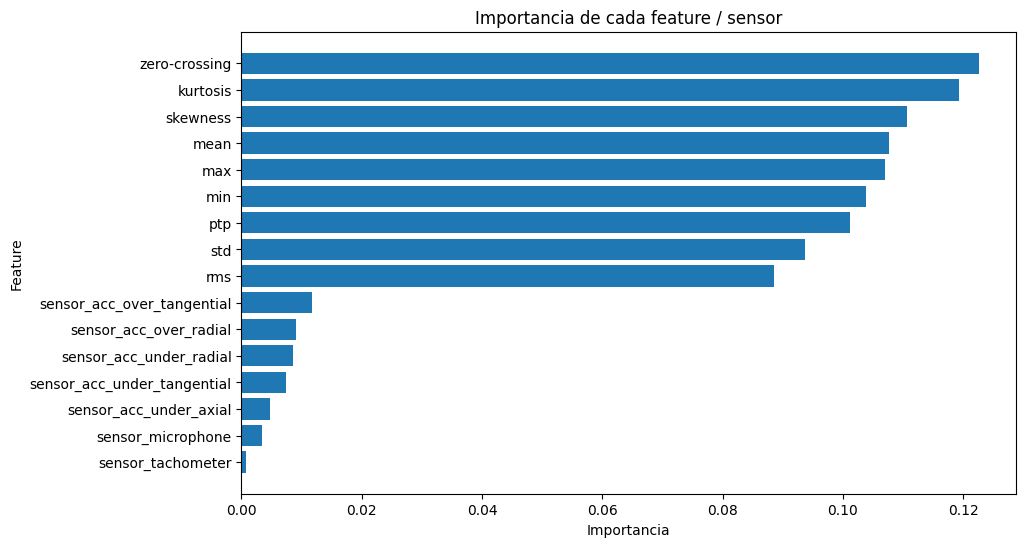

In [28]:
importances = rf.feature_importances_
feature_names = X_train.columns  # Use X_train.columns which reflect the encoded features
feat_imp_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False)
print(feat_imp_df)

plt.figure(figsize=(10,6))
plt.barh(feat_imp_df['feature'], feat_imp_df['importance'])
plt.xlabel('Importancia')
plt.ylabel('Feature')
plt.title('Importancia de cada feature / sensor')
plt.gca().invert_yaxis()
plt.show()

In [29]:
unique_sensors = df['sensor'].unique().tolist()
print(f"Unique sensor names: {unique_sensors}")

Unique sensor names: ['tachometer', 'acc_under_axial', 'acc_under_radial', 'acc_under_tangential', 'acc_over_axial', 'acc_over_radial', 'acc_over_tangential', 'microphone']


In [30]:
sensor_feature_importances = {}

for sensor_name in unique_sensors:
    sensor_df = df[df['sensor'] == sensor_name]

    y_sensor = sensor_df['condition']
    X_sensor = sensor_df.drop(columns=['condition', 'sensor'])

    if len(X_sensor) == 0 or len(X_sensor.columns) == 0:
        print(f"Skipping sensor '{sensor_name}' due to insufficient data for training.")
        continue

    rf_sensor = RandomForestClassifier(random_state=42)
    rf_sensor.fit(X_sensor, y_sensor)

    importances = rf_sensor.feature_importances_
    feature_names = X_sensor.columns

    sensor_feature_importances[sensor_name] = dict(zip(feature_names, importances))

print("Feature importances calculated for each sensor:")
for sensor, importances in sensor_feature_importances.items():
    print(f"\nSensor: {sensor}")

    sorted_importances = sorted(importances.items(), key=lambda item: item[1], reverse=True)
    for feature, importance in sorted_importances:
        print(f"  {feature}: {importance:.4f}")

Feature importances calculated for each sensor:

Sensor: tachometer
  mean: 0.1373
  min: 0.1231
  zero-crossing: 0.1165
  ptp: 0.1138
  skewness: 0.1076
  kurtosis: 0.1043
  max: 0.0995
  std: 0.0993
  rms: 0.0985

Sensor: acc_under_axial
  min: 0.1637
  ptp: 0.1289
  mean: 0.1158
  max: 0.1073
  zero-crossing: 0.1072
  rms: 0.1045
  std: 0.1011
  skewness: 0.0939
  kurtosis: 0.0775

Sensor: acc_under_radial
  kurtosis: 0.2287
  skewness: 0.1402
  max: 0.1166
  zero-crossing: 0.1103
  min: 0.0933
  rms: 0.0869
  std: 0.0836
  ptp: 0.0747
  mean: 0.0657

Sensor: acc_under_tangential
  zero-crossing: 0.1816
  skewness: 0.1770
  kurtosis: 0.1463
  min: 0.1072
  rms: 0.0926
  ptp: 0.0820
  max: 0.0797
  std: 0.0741
  mean: 0.0594

Sensor: acc_over_axial
  min: 0.1571
  zero-crossing: 0.1534
  ptp: 0.1403
  max: 0.1165
  rms: 0.1004
  std: 0.0998
  kurtosis: 0.0875
  skewness: 0.0783
  mean: 0.0668

Sensor: acc_over_radial
  skewness: 0.1268
  min: 0.1254
  zero-crossing: 0.1253
  std: 0.1

In [31]:
feature_importance_df = pd.DataFrame(sensor_feature_importances).T
print(feature_importance_df)

                          mean       std       rms       min       max  \
tachometer            0.137317  0.099284  0.098514  0.123092  0.099516   
acc_under_axial       0.115835  0.101150  0.104472  0.163703  0.107281   
acc_under_radial      0.065686  0.083615  0.086912  0.093334  0.116579   
acc_under_tangential  0.059384  0.074052  0.092635  0.107222  0.079650   
acc_over_axial        0.066831  0.099780  0.100413  0.157113  0.116470   
acc_over_radial       0.086591  0.121317  0.119564  0.125353  0.078853   
acc_over_tangential   0.122348  0.088587  0.075835  0.102853  0.084222   
microphone            0.112429  0.093426  0.087247  0.161636  0.083063   

                           ptp  kurtosis  skewness  zero-crossing  
tachometer            0.113843  0.104321  0.107641       0.116471  
acc_under_axial       0.128894  0.077548  0.093896       0.107221  
acc_under_radial      0.074676  0.228750  0.140152       0.110297  
acc_under_tangential  0.082046  0.146314  0.177048       0.18

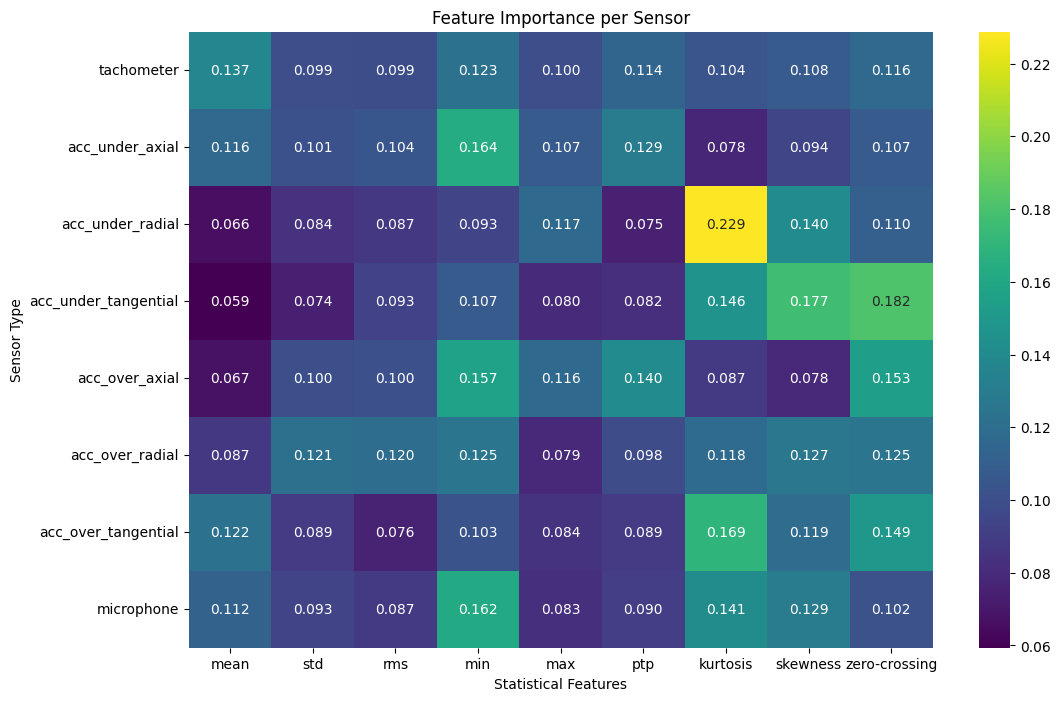

In [32]:
plt.figure(figsize=(12, 8))
sns.heatmap(feature_importance_df, annot=True, cmap='viridis', fmt=".3f")
plt.title('Feature Importance per Sensor')
plt.xlabel('Statistical Features')
plt.ylabel('Sensor Type')
plt.show()

# Ajuste hiperparametros

In [33]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10]
}

print("Hyperparameter search space defined:")
print(param_grid)

Hyperparameter search space defined:
{'n_estimators': [100, 200, 300], 'max_depth': [10, 20, 30, None], 'min_samples_leaf': [1, 2, 4], 'min_samples_split': [2, 5, 10]}


In [37]:
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           scoring='f1_weighted', cv=5, verbose=2, n_jobs=4)

grid_search.fit(X_train, y_train)

print("GridSearchCV completed.")

Fitting 5 folds for each of 108 candidates, totalling 540 fits
GridSearchCV completed.


In [38]:
best_rf_model = grid_search.best_estimator_
print("Best RandomForestClassifier model retrieved from GridSearchCV:")
print(best_rf_model)

Best RandomForestClassifier model retrieved from GridSearchCV:
RandomForestClassifier(max_depth=30, random_state=42)


Classification Report for Tuned Model:
                         precision    recall  f1-score   support

horizontal-misalignment       0.35      0.23      0.28        26
              imbalance       0.48      0.47      0.47        45
                 normal       0.00      0.00      0.00         6
               overhang       0.55      0.64      0.59        77
              underhang       0.57      0.65      0.61        77
  vertical-misalignment       0.43      0.34      0.38        38

               accuracy                           0.52       269
              macro avg       0.40      0.39      0.39       269
           weighted avg       0.50      0.52      0.50       269



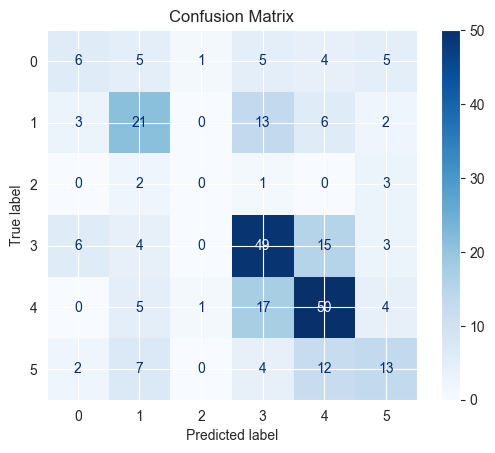

In [41]:
y_pred_tuned = best_rf_model.predict(X_test)
print("Classification Report for Tuned Model:")
print(classification_report(y_test, y_pred_tuned))
cm = confusion_matrix(y_test, y_pred_tuned)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format="d")

plt.title("Confusion Matrix")
plt.show()